<center>
<img src="https://i.pinimg.com/originals/35/22/fb/3522fb7f22a318b70b6f07b78f52e62c.png" alt="Image" style="width:50%;height:50%;margin:auto">
</center>

# What is AQI ?
```
Air Quality Index (AQI) is a number used to convey the quality of air by the government to the general public. Air quality deteriorates with an increase in the concentration of pollutants. The Air Quality Index represents the severity of pollution for ordinary people.
```

# Indian AQI range & probable impacts:
    
| AQI Range|Color Code | Possible Health Impacts |
| :-:|:-:|:-:|
|```0-50```| <div style="background-color: #377a07">Good</div> |Minimal impact|
|```51-100```|<div style="background-color: #9acd32">Satisfactory</div>|Minor breathing discomfort to sensitive people|
|```101-200```|<div style="background-color: #f4f805">Moderate</div>|Breathing discomfort to the people with lungs, asthma and heart diseases|
|```201-300```|<div style="background-color: #f58f09">Poor</div>|Breathing discomfort to most people on prolonged exposure|
|```301-400```|<div style="background-color: #c41206">Very Poor</div>|Respiratory illness on prolonged exposure|
|```401-500```|<div style="background-color: #810100">Severe</div>|Affects healthy people and seriously impacts those with existing diseases|

In [1]:
import re
import requests
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# For Plotting
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Extraction

### I have tried to show how we can scrap the data in some basic steps. I Have used the [Air Matters](https://air-quality.com/)  for scraping the data of some cities mentioned in this site.

In [2]:
# Example with one url
city_url="https://air-quality.com/place/india/akasahebpeta/e683280a?lang=en&standard=naqi_in"
city_url

'https://air-quality.com/place/india/akasahebpeta/e683280a?lang=en&standard=naqi_in'

In [3]:
city_response = requests.get(city_url)
city_soup = BeautifulSoup(city_response.content, "html.parser")

# Extract the city name and state name
city_name = city_soup.find("h2").text.strip()
state_name = city_soup.find("p").text.strip().split(", ")[1]
print(f"{state_name}, {city_name}")

Andhra Pradesh, Akasahebpeta


In [4]:
# Extract AQI value from HTML comment
aqi_comment = city_soup.find(text=lambda text: isinstance(text, Comment) and "indexValue" in text)
aqi_value = re.search(r"\d+", aqi_comment).group() if aqi_comment else np.NaN
print(aqi_value)

91


In [5]:
# Extract pollutant information
pollutants = city_soup.find_all("div", class_="pollutant-item")

pollutant_data = {}
for pollutant in pollutants:
    name = pollutant.find("div", class_="name").text.strip()
    value = pollutant.find("div", class_="value").text.strip()
    pollutant_data[name] = value

print(pollutant_data.get("PM2.5"), pollutant_data.get("PM10"), pollutant_data.get("O3"), pollutant_data.get("SO2"), pollutant_data.get("CO"))

55 87 23 8 620


In [6]:
# Extract weather information
temperature = city_soup.find("div", class_="temperature").text.strip().replace("℃", "")
humidity = city_soup.find("div", class_="humidity").text.strip().replace("%", "")
wind_speed = city_soup.find("div", class_="wind").text.strip().replace("kph", "")
type = city_soup.find("div", class_="level").text.strip()
print(temperature,humidity,wind_speed,type)

31 46 5  Satisfactory


In [7]:
# Check if GPU is available and use it if possible
use_gpu = False
try:
    import cupy as cp
    use_gpu = True
except ImportError:
    pass

# Web Scrapping

In [8]:
url = "https://air-quality.com/country/india/3ffd900b?lang=en&standard=naqi_in"

# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")

# Find all the site-item links
site_items = soup.find_all("a", class_="site-item")

data = []

# Function to process each city href
def process_city_href(city_href):
    city_response = requests.get(city_href)
    city_soup = BeautifulSoup(city_response.content, "html.parser")

    # Extract the city name and state name
    city_name = city_soup.find("h2").text.strip()
    state_name = city_soup.find("p").text.strip().split(", ")[1]

    # Extract AQI value from HTML comment
    aqi_comment = city_soup.find(string=lambda text: isinstance(text, Comment) and "indexValue" in text)
    aqi_value = float(re.search(r"\d+", aqi_comment).group()) if aqi_comment else np.NaN

    # Extract pollutant information
    pollutants = city_soup.find_all("div", class_="pollutant-item")

    pollutant_data = {}
    for pollutant in pollutants:
        name = pollutant.find("div", class_="name").text.strip()
        value = pollutant.find("div", class_="value").text.strip()
        pollutant_data[name] = float(value) if value else np.NaN

    # Extract weather information
    temperature = float(city_soup.find("div", class_="temperature").text.strip().replace("℃", "")) or np.NaN
    humidity = float(city_soup.find("div", class_="humidity").text.strip().replace("%", "")) or np.NaN
    wind_speed = float(city_soup.find("div", class_="wind").text.strip().replace("kph", "")) or np.NaN
    type = city_soup.find("div", class_="level").text.strip()
    type=type.replace("Moderately polluted", "Moderate")

    # Append data to the list
    data.append([state_name, city_name,pollutant_data.get("PM2.5"), pollutant_data.get("PM10"), pollutant_data.get("O3"),pollutant_data.get("SO2"), pollutant_data.get("CO"),wind_speed, humidity, temperature, aqi_value,type])

# Use thread pooling to process city hrefs
with ThreadPoolExecutor(max_workers=200) as executor:
    # Extract city hrefs from each state href
    for site_item in site_items:
        state_href = site_item["href"]
        # Send a GET request to the state href
        state_response = requests.get(state_href)
        # Create a BeautifulSoup object to parse the HTML content of the state href
        state_soup = BeautifulSoup(state_response.content, "html.parser")
        # Find all the city hrefs
        all_city_hrefs = state_soup.find_all("a", class_="site-item")
        for city_href in all_city_hrefs:
            city_href = city_href["href"]
            if "https://air-quality.com/place/india" in city_href:
                # Submit the city href for processing in the thread pool
                executor.submit(process_city_href, city_href)   

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=["State", "City", "PM2.5", "PM10", "O3", "SO2", "CO", "Wind Speed", "Humidity", "Temp", "AQI","AQI Type"])

In [9]:
df

,State,City,PM2.5,PM10,O3,SO2,CO,Wind Speed,Humidity,Temp,AQI,AQI Type
0,Andaman and Nicobar Islands,Port Blair,12.0,20.0,NaN,NaN,NaN,11.0,74.0,30.0,20.0,Good
1,Andhra Pradesh,Addanki,35.0,52.0,18.0,6.0,521.0,10.0,62.0,29.0,58.0,Satisfactory
2,Andhra Pradesh,Ongole,37.0,56.0,19.0,6.0,543.0,13.0,60.0,29.0,61.0,Satisfactory
3,Andhra Pradesh,Vinukonda,37.0,54.0,23.0,13.0,682.0,9.0,63.0,28.0,61.0,Satisfactory
4,Andhra Pradesh,Pavuluru,37.0,56.0,19.0,6.0,543.0,10.0,64.0,28.0,61.0,Satisfactory
...,...,...,...,...,...,...,...,...,...,...,...,...
398,West Bengal,Bhanjipur,67.0,131.0,18.0,3.0,716.0,14.0,35.0,31.0,123.0,Moderate
399,West Medinipur,Ramjibanpur,58.0,84.0,6.0,1.0,206.0,14.0,35.0,31.0,97.0,Satisfactory
400,West Bengal,Patrasayer,54.0,78.0,2.0,11.0,552.0,13.0,34.0,31.0,90.0,Satisfactory
401,West Bengal,Bagnan,67.0,131.0,18.0,3.0,716.0,15.0,35.0,30.0,123.0,Moderate


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   State       403 non-null    object 
 1   City        403 non-null    object 
 2   PM2.5       403 non-null    float64
 3   PM10        403 non-null    float64
 4   O3          278 non-null    float64
 5   SO2         308 non-null    float64
 6   CO          323 non-null    float64
 7   Wind Speed  400 non-null    float64
 8   Humidity    403 non-null    float64
 9   Temp        403 non-null    float64
 10  AQI         403 non-null    float64
 11  AQI Type    403 non-null    object 
dtypes: float64(9), object(3)
memory usage: 37.9+ KB


In [11]:
df["AQI Type"].unique()

array(['Good', 'Satisfactory', 'Moderate', 'Poor'], dtype=object)

# Looking at Missing Values

In [12]:
df.isna().sum()

State           0
City            0
PM2.5           0
PM10            0
O3            125
SO2            95
CO             80
Wind Speed      3
Humidity        0
Temp            0
AQI             0
AQI Type        0
dtype: int64

In [13]:
# Create a boolean mask indicating which rows have missing values
mask = df.isna().any(axis=1)

# Use the mask to filter the DataFrame and display the rows with missing values
rows_with_missing_values = df[mask]

# Print the rows
rows_with_missing_values

,State,City,PM2.5,PM10,O3,SO2,CO,Wind Speed,Humidity,Temp,AQI,AQI Type
0,Andaman and Nicobar Islands,Port Blair,12.0,20.0,NaN,NaN,NaN,11.0,74.0,30.0,20.0,Good
29,Assam,Lumding,17.0,25.0,NaN,9.0,380.0,4.0,52.0,28.0,29.0,Good
32,Assam,Diphu,17.0,25.0,NaN,9.0,380.0,3.0,51.0,29.0,29.0,Good
57,Chhattisgarh,Dhamtari,42.0,61.0,NaN,NaN,NaN,7.0,37.0,30.0,70.0,Satisfactory
66,Maharashtra,Dahanu,53.0,90.0,NaN,NaN,NaN,5.0,51.0,32.0,90.0,Satisfactory
...,...,...,...,...,...,...,...,...,...,...,...,...
365,Mizoram,Sairang,26.0,37.0,NaN,NaN,NaN,9.0,51.0,31.0,42.0,Good
366,Tripura,Udaipur,36.0,51.0,NaN,NaN,NaN,6.0,48.0,30.0,59.0,Satisfactory
367,Tripura,Ambassa,36.0,51.0,NaN,NaN,NaN,3.0,42.0,30.0,59.0,Satisfactory
368,Tripura,Dharmanagar,27.0,38.0,NaN,9.0,383.0,3.0,45.0,30.0,44.0,Good


# Normalization of Data

### Why not use Mean, Median, Mode or any simple Normalization Techniques?

Since the amount of data in the dataset is quite low, we want to maintain the data so that it is approximately equivalent to the missing value. However, if we replace the data with the mean, the median, or the mode, the credibility of the data will diminish as a result, we will need to do something else.

### Using Iterative Imputer

Iterative imputer is a method for filling in missing values in a dataset by making multiple passes over the data and guessing missing values based on the observed values and links between variables. It uses models of machine learning to make guesses about missing numbers until agreement is reached.

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_data = df.drop(columns=["State","City","AQI Type"])

# Initialize the IterativeImputer with the desired parameters
imputer = IterativeImputer()

# Perform imputation on the selected columns
imputed_data = imputer.fit_transform(impute_data)
imputed_data[0]

array([ 12.        ,  20.        ,  -0.98259521,   6.16748262,
       253.78626391,  11.        ,  74.        ,  30.        ,
        20.        ])

### Using KNN Imputer

The K-nearest neighbours algorithm is used in the KNN imputer method to fill in empty numbers. It finds the K closest examples to the one with the missing value and uses their known values to guess the missing value.

In [15]:
from sklearn.impute import KNNImputer

impute_data = df.drop(columns=["State","City","AQI Type"])

# Initialize the KNNImputer with the desired parameters
imputer = KNNImputer(n_neighbors=3,weights="uniform")

# Perform imputation on the selected columns
impute_data=imputer.fit_transform(impute_data)
impute_data[0]

array([ 12.,  20.,   1.,  10., 359.,  11.,  74.,  30.,  20.])

In [16]:
df.iloc[0]

State         Andaman and Nicobar Islands
City                           Port Blair
PM2.5                                12.0
PM10                                 20.0
O3                                    NaN
SO2                                   NaN
CO                                    NaN
Wind Speed                           11.0
Humidity                             74.0
Temp                                 30.0
AQI                                  20.0
AQI Type                             Good
Name: 0, dtype: object

### ```Note:``` From the above we can determine that the KNN Imputer will be best for normalizing the data.

### Replacing the Value

In [17]:
df[["PM2.5", "PM10", "O3", "SO2", "CO", "Wind Speed", "Humidity", "Temp", "AQI"]] = impute_data

In [18]:
df.isna().sum()

State         0
City          0
PM2.5         0
PM10          0
O3            0
SO2           0
CO            0
Wind Speed    0
Humidity      0
Temp          0
AQI           0
AQI Type      0
dtype: int64

# EDA

In [23]:
import plotly.graph_objects as go
import plotly.io as pio# Calculate correlation matrix
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# corr_matrix = df.corr()

# # Define colorscale
# colorscale = [[0, '#ff0000'], [1, '#00b050']]

# # Create heatmap trace
# trace = go.Heatmap(
#     z=corr_matrix.values,
#     x=corr_matrix.columns,
#     y=corr_matrix.columns,
#     colorscale=colorscale,
#     colorbar=dict(title='Correlation'),
#     hovertemplate='Correlation: %{z:.2f}',
# )

# # Create a figure
# fig = go.Figure(data=trace)

# # Customize the graph layout
# fig.update_layout(
#     title='Correlation Matrix',
#     width=800,
#     height=600,
#     xaxis=dict(tickangle=-45),
#     yaxis=dict(tickangle=45),
# )

# # Display the plot
# fig.show()
# output_filename = 'corrmat.png'
# pio.write_image(fig, output_filename, format='png')

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Define colorscale
colorscale = [[0, '#ff0000'], [1, '#00b050']]

# Create heatmap trace
trace = go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale=colorscale,
    colorbar=dict(title='Correlation'),
    hovertemplate='Correlation: %{z:.2f}',
)

# Create a figure
fig = go.Figure(data=trace)

# Customize the graph layout
fig.update_layout(
    title='Correlation Matrix',
    width=800,
    height=600,
    xaxis=dict(tickangle=-45),
    yaxis=dict(tickangle=45),
)

# Display the plot
fig.show()

output_filename = 'corrmat.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


## Conclusion from the correlation matrix

From this we get to know that All the features are somewhat related to the Taget Variable (AQI) Except of 1 feature that is not related to any of the other features that is our ```Humidity``` so in thus in the further section we are going to drop that column in the Data Preprocessing or Feature Scalling Section.

### Now we will hae a Look at the Distribution of the AQI Type over the AQI Values

In [24]:
# Count the occurrences of each AQI type
aqi_type_counts = df["AQI Type"].value_counts()

# Create a bar graph
fig = go.Figure(data=[go.Bar(x=aqi_type_counts.index, y=aqi_type_counts.values)])

# Customize the graph layout
fig.update_layout(
    title='AQI Type Counts',
    xaxis=dict(title='AQI Type'),
    yaxis=dict(title='Count'),
)

# Display the graph
fig.show()
output_filename = 'aqi_occ_bar.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [25]:
# Set color mapping for each AQI type
color_mapping = {
    'Good': '#377a07',
    'Satisfactory': '#9acd32',
    'Moderate': '#f4f805',
    'Poor': '#f58f09',
    'Very Poor': '#c41206',
    'Severe': '#810100'
}

In [26]:
import plotly.graph_objects as go

# Count the occurrences of each AQI type
aqi_type_counts = df["AQI Type"].value_counts()

# Create a pie chart
fig = go.Figure(data=[go.Pie(
    labels=aqi_type_counts.index,
    values=aqi_type_counts.values,
    hole=0.4,
    hovertemplate="<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent:.2%}",
    marker=dict(
        colors=[color_mapping[aqi_type] for aqi_type in aqi_type_counts.index],
        line=dict(color='rgba(0, 0, 0, 0.5)', width=1),
    ),
)])

# Customize the graph layout
fig.update_layout(
    title='AQI Type Counts',
    showlegend=True,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
)

# Add custom CSS styling for shadow effect
fig.update_layout(
    template="plotly_dark",
    autosize=True,
    width=600,
    height=400,
    margin=dict(l=0, r=0, b=0, t=60),
    hoverlabel=dict(bgcolor="rgba(0, 0, 0, 0.7)", font=dict(color="white")),
    font=dict(color="Black"),
    showlegend=True
)

# Display the graph
fig.show()
output_filename = 'aqi_occ_pie.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [27]:
# Set figure size
fig = px.strip(df, x='AQI Type', y='AQI',
               category_orders={'AQI Type': ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']},
               color='AQI Type', color_discrete_map=color_mapping)

# Customize the graph layout
fig.update_layout(
    title='AQI Type Distribution',
    xaxis=dict(title='AQI Type'),
    yaxis=dict(title='AQI Value'),
)

# Display the plot
fig.show()
output_filename = 'aqi_distri.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


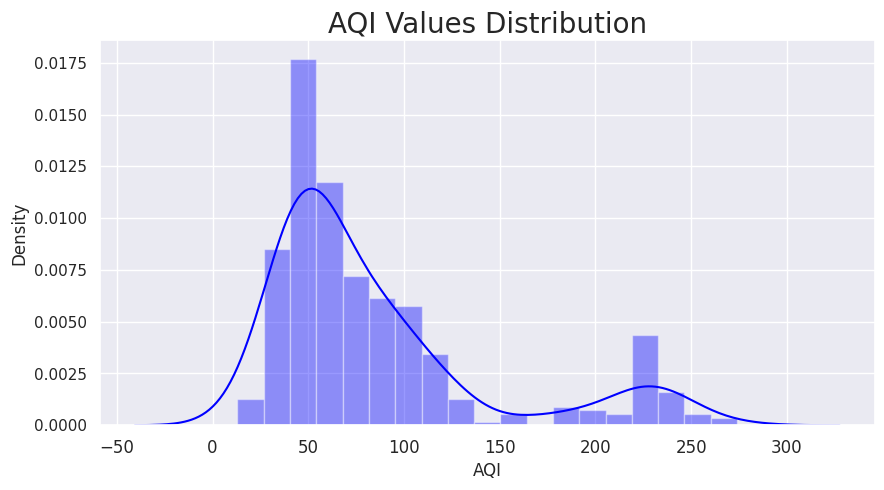

In [28]:
sns.set(rc={'figure.figsize':(10,5)})
plt.xticks(fontsize=12)
p=sns.distplot(df['AQI'],color='Blue')
p.axes.set_title("AQI Values Distribution",fontsize=20);
output_filename = 'aqi_density.png'
pio.write_image(fig, output_filename, format='png')

### Having a Look at the outliers in the Dataset

In [ ]:
# Set figure size
fig = px.box(df, x='AQI Type', y='AQI',color='AQI Type', color_discrete_map=color_mapping,
             category_orders={'AQI Type': ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']})

# Customize the graph layout
fig.update_layout(
    title='AQI Values by AQI Type',
    xaxis=dict(title='AQI Type'),
    yaxis=dict(title='AQI Value'),
)

# Display the plot
fig.show()
output_filename = 'boxplot_outliers.png'
pio.write_image(fig, output_filename, format='png')

In [29]:
# Set figure size
fig = px.violin(df, x='AQI Type', y='AQI',
                color='AQI Type', color_discrete_map=color_mapping,
                category_orders={'AQI Type': ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']})

# Customize the graph layout
fig.update_layout(
    title='AQI Values by AQI Type',
    xaxis=dict(title='AQI Type'),
    yaxis=dict(title='AQI Value'),
)

# Display the plot
fig.show()
output_filename = 'aqi_val_by_types.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


# Top 10 Polluted Cities in the Dataset

In [30]:
import plotly.graph_objects as go

# Remove duplicate cities
df_unique = df.drop_duplicates(subset='City')

# Sort the DataFrame by AQI in descending order
df_sorted = df_unique.sort_values('AQI', ascending=False)

# Get the top 10 polluted cities
top_polluted_cities = df_sorted.head(10)

# Create a bar graph for polluted cities
fig = go.Figure(data=[go.Bar(x=top_polluted_cities['City'], y=top_polluted_cities['AQI'],marker=dict(color='red'),text=top_polluted_cities['AQI'],textposition='auto')])
fig.update_layout(
    title='Top 10 Polluted Cities',
    xaxis=dict(title='City'),
    yaxis=dict(title='AQI'),
)

# Display the graph
fig.show()
output_filename = 'polluted10.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


# Top 10 leanest City in the Dataset

In [31]:
import plotly.graph_objects as go

# Get the top 10 cleansed cities
top_cleansed_cities = df_sorted.tail(10)[::-1]

# Create a bar graph for cleansed cities
fig = go.Figure(data=[go.Bar(x=top_cleansed_cities['City'], y=top_cleansed_cities['AQI'],marker=dict(color='green'),text=top_cleansed_cities['AQI'],textposition='auto')])
fig.update_layout(
    title='Top 10 Cleansed Cities',
    xaxis=dict(title='City'),
    yaxis=dict(title='AQI'),
)

# Display the graph
fig.show()
output_filename = 'clean10.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


# Having a look at the Geo Locations and their effects

In [32]:
from geopy.geocoders import Nominatim
import folium

states = df['State'].unique()

geolocator = Nominatim(user_agent="my_app")

lat_lng_data = []
for state in states:
    location = geolocator.geocode(state)
    if location:
        lat_lng_data.append((state, location.latitude, location.longitude))
    else:
        lat_lng_data.append((state, None, None))

df_lat_lng = pd.DataFrame(lat_lng_data, columns=["State", "Latitude", "Longitude"])
merged_df = df.merge(df_lat_lng, on="State", how="left")

In [33]:
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.figure as mfig

# Calculate the average AQI and pollutant values for each state
avg_data_by_state = merged_df.groupby(["State", "Latitude", "Longitude"]).agg({
    "AQI": "mean",
    "PM10": "mean",
    "CO": "mean",
    "O3": "mean",
    "SO2": "mean",
    "PM2.5": "mean"
}).reset_index()

# Define the color scale based on the AQI ranges
color_scale = [
    "#377a07",  # 0-50
    "#9acd32",  # 51-100
    "#f4f805",  # 101-200
    "#f58f09",  # 201-300
    "#c41206",  # 301-400
    "#810100"   # 401-500
]

# Create the bubble graph
fig = px.scatter_mapbox(
    avg_data_by_state,
    lat="Latitude",
    lon="Longitude",
    size="AQI",
    color="AQI",
    color_continuous_scale=color_scale,
    hover_name="State",
    hover_data={
        "AQI": ":.2f",
        "PM10": ":.2f",
        "CO": ":.2f",
        "O3": ":.2f",
        "SO2": ":.2f",
        "PM2.5": ":.2f"
    },
    zoom=4,
    center={"lat": 22, "lon": 79},
    mapbox_style="open-street-map",
    title="Average AQI and Pollutant Values by State in India",
    width=900,
    height=700
)

# Update the layout
fig.update_layout(
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    autosize=True,
    hovermode="closest",
    coloraxis_colorbar=dict(
        title="Avg AQI",
        xpad=0,
        lenmode="pixels",
        yanchor="middle",
        tickformat=".2f",
    )
)

# Show the bubble graph
fig.show()
fig.write_html("map.html")

# Feature Scalling

### Since the State and City Names does not help us in predicting the AQI Value so we will be Dropping that Columns.

In [34]:
df = df.drop(columns=["State","City","AQI Type","Humidity"])

In [35]:
df

,PM2.5,PM10,O3,SO2,CO,Wind Speed,Temp,AQI
0,12.0,20.0,1.0,10.0,359.0,11.0,30.0,20.0
1,35.0,52.0,18.0,6.0,521.0,10.0,29.0,58.0
2,37.0,56.0,19.0,6.0,543.0,13.0,29.0,61.0
3,37.0,54.0,23.0,13.0,682.0,9.0,28.0,61.0
4,37.0,56.0,19.0,6.0,543.0,10.0,28.0,61.0
...,...,...,...,...,...,...,...,...
398,67.0,131.0,18.0,3.0,716.0,14.0,31.0,123.0
399,58.0,84.0,6.0,1.0,206.0,14.0,31.0,97.0
400,54.0,78.0,2.0,11.0,552.0,13.0,31.0,90.0
401,67.0,131.0,18.0,3.0,716.0,15.0,30.0,123.0


In [36]:
X = df.drop("AQI", axis=1)  # Input features
y = df["AQI"]  # Target variable

#### Common techniques for feature scaling include:

1. ```Min-Max Scaling (Normalization):``` Rescales the values to a specific range (e.g., between 0 and 1) using the formula: (x - min) / (max - min), where x is the original value, min is the minimum value in the feature, and max is the maximum value.

In [37]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
min_max_scaled = min_max_scaler.fit_transform(X)
min_max_df = pd.DataFrame(min_max_scaled, columns=X.columns)

min_max_df.head()

,PM2.5,PM10,O3,SO2,CO,Wind Speed,Temp
0,0.038462,0.059211,0.000000,0.409091,0.101871,0.416667,0.777778
1,0.259615,0.269737,0.333333,0.227273,0.169231,0.375000,0.740741
2,0.278846,0.296053,0.352941,0.227273,0.178378,0.500000,0.740741
3,0.278846,0.282895,0.431373,0.545455,0.236175,0.333333,0.703704
4,0.278846,0.296053,0.352941,0.227273,0.178378,0.375000,0.703704


2. ```Standardization:``` Transforms the values to have zero mean and unit variance using the formula: (x - mean) / standard deviation, where x is the original value, mean is the average value of the feature, and standard deviation is the standard deviation of the feature.

In [38]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaled = standard_scaler.fit_transform(X)
standard_df = pd.DataFrame(standard_scaled, columns=X.columns)

standard_df.head()

,PM2.5,PM10,O3,SO2,CO,Wind Speed,Temp
0,-1.395872,-1.366253,-1.177955,0.156716,-0.631202,0.373231,0.568961
1,-0.443543,-0.479261,0.261005,-0.526056,-0.218331,0.155977,0.328109
2,-0.360732,-0.368388,0.345650,-0.526056,-0.162262,0.807739,0.328109
3,-0.360732,-0.423825,0.684229,0.668795,0.191992,-0.061277,0.087257
4,-0.360732,-0.368388,0.345650,-0.526056,-0.162262,0.155977,0.087257


#### Other Techniques are:
1. ```Robust Scaling:``` This method is similar to standardization but is more robust to outliers. It scales the data using the median and interquartile range (IQR) instead of the mean and standard deviation.

In [39]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
robust_scaled = robust_scaler.fit_transform(X)
robust_df = pd.DataFrame(robust_scaled, columns=X.columns)

robust_df.head()

,PM2.5,PM10,O3,SO2,CO,Wind Speed,Temp
0,-0.806452,-0.857143,-0.666667,0.238095,-0.474839,0.4,0.50
1,-0.064516,-0.095238,0.142857,-0.333333,-0.056774,0.2,0.25
2,0.000000,0.000000,0.190476,-0.333333,0.000000,0.8,0.25
3,0.000000,-0.047619,0.380952,0.666667,0.358710,0.0,0.00
4,0.000000,0.000000,0.190476,-0.333333,0.000000,0.2,0.00


2. ```Log Transformation:``` If the data has a skewed distribution, applying a logarithmic transformation can help normalize the values. This is particularly useful for data that spans several orders of magnitude.

In [40]:
import numpy as np

log_transformed = np.log1p(X)
log_transformed.head()

,PM2.5,PM10,O3,SO2,CO,Wind Speed,Temp
0,2.564949,3.044522,0.693147,2.397895,5.886104,2.484907,3.433987
1,3.583519,3.970292,2.944439,1.945910,6.257668,2.397895,3.401197
2,3.637586,4.043051,2.995732,1.945910,6.298949,2.639057,3.401197
3,3.637586,4.007333,3.178054,2.639057,6.526495,2.302585,3.367296
4,3.637586,4.043051,2.995732,1.945910,6.298949,2.397895,3.367296


3. ```Power Transformation:``` Power transformations, such as the Box-Cox or Yeo-Johnson transform, can be used to stabilize variance and normalize the data. These transformations are effective for data with skewed or non-normal distributions.

In [41]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson')
power_transformed = power_transformer.fit_transform(X)
power_df = pd.DataFrame(power_transformed, columns=X.columns)

power_df.head()

,PM2.5,PM10,O3,SO2,CO,Wind Speed,Temp
0,-2.407366,-2.114540,-1.542200,0.342245,-0.582993,0.492206,0.531619
1,-0.264923,-0.317792,0.508195,-0.377369,0.005888,0.289649,0.219619
2,-0.154762,-0.174233,0.571901,-0.377369,0.073297,0.868393,0.219619
3,-0.154762,-0.244750,0.806008,0.775307,0.452199,0.075527,-0.070093
4,-0.154762,-0.174233,0.571901,-0.377369,0.073297,0.289649,-0.070093


4. ```Decimal Scaling:``` In this method, the feature values are scaled by dividing them by an appropriate power of 10. This makes the values fall within a specific range, such as [-1, 1] or [0, 1], without losing the relative differences between the values.

In [42]:
decimal_scaled = X / 100
decimal_df = decimal_scaled.round(2)

decimal_df.head()

,PM2.5,PM10,O3,SO2,CO,Wind Speed,Temp
0,0.12,0.20,0.01,0.10,3.59,0.11,0.30
1,0.35,0.52,0.18,0.06,5.21,0.10,0.29
2,0.37,0.56,0.19,0.06,5.43,0.13,0.29
3,0.37,0.54,0.23,0.13,6.82,0.09,0.28
4,0.37,0.56,0.19,0.06,5.43,0.10,0.28


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Define the regression algorithm
regressor = LinearRegression()

# Prepare the scaled datasets
min_max_scaled = min_max_scaler.fit_transform(X)
standard_scaled = standard_scaler.fit_transform(X)
robust_scaled = robust_scaler.fit_transform(X)
log_transformed = np.log1p(X)
power_transformer = PowerTransformer(method='yeo-johnson')
power_transformed = power_transformer.fit_transform(df)
decimal_scaled = X / 100

# Evaluate performance using cross-validation
scores_min_max = cross_val_score(regressor, min_max_scaled, y, cv=5, scoring='neg_mean_squared_error')
scores_standard = cross_val_score(regressor, standard_scaled, y, cv=5, scoring='neg_mean_squared_error')
scores_robust = cross_val_score(regressor, robust_scaled, y, cv=5, scoring='neg_mean_squared_error')
scores_log = cross_val_score(regressor, log_transformed, y, cv=5, scoring='neg_mean_squared_error')
scores_power = cross_val_score(regressor, power_transformed, y, cv=5, scoring='neg_mean_squared_error')
scores_decimal = cross_val_score(regressor, decimal_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean squared error for each scaling method
mse_min_max = -np.mean(scores_min_max)
mse_standard = -np.mean(scores_standard)
mse_robust = -np.mean(scores_robust)
mse_log = -np.mean(scores_log)
mse_power = -np.mean(scores_power)
mse_decimal = -np.mean(scores_decimal)

# Print the mean squared error for each scaling method
print(f"Mean Squared Error (Min-Max Scaling): {mse_min_max}")
print(f"Mean Squared Error (Standardization): {mse_standard}")
print(f"Mean Squared Error (Robust Scaling): {mse_robust}")
print(f"Mean Squared Error (Log Transformation): {mse_log}")
print(f"Mean Squared Error (Power Transformer): {mse_power}")
print(f"Mean Squared Error (Decimal Scaling): {mse_decimal}")

Mean Squared Error (Min-Max Scaling): 118.57862267472187
Mean Squared Error (Standardization): 118.57862267472228
Mean Squared Error (Robust Scaling): 118.57862267472179
Mean Squared Error (Log Transformation): 537.021215348836
Mean Squared Error (Power Transformer): 508.8828238655171
Mean Squared Error (Decimal Scaling): 118.57862267472194


In [44]:
mse_values = np.array([mse_min_max,mse_standard,mse_robust,mse_log,mse_power,mse_decimal])

# Get the index of the minimum MSE
min_mse_index = np.argmin(mse_values)

# List of scaling methods
scaling_methods = ['Min-Max Scaling', 'Standardization', 'Robust Scaling',
                   'Log Transformation', 'Power Transformer', 'Decimal Scaling']

selected_method = scaling_methods[min_mse_index]
selected_method

'Robust Scaling'

# Train Test Split

In [45]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Apply the selected scaling method to the training and testing sets
if selected_method == 'Min-Max Scaling':
    scaler = MinMaxScaler()
elif selected_method == 'Standardization':
    scaler = StandardScaler()
elif selected_method == 'Robust Scaling':
    scaler = RobustScaler()
elif selected_method == 'Log Transformation':
    scaler = None  # No scaling required for log transformation
elif selected_method == 'Power Transformer':
    scaler = PowerTransformer(method='yeo-johnson')
elif selected_method == 'Decimal Scaling':
    scaler = None  # No scaling required for decimal scaling

if scaler is not None:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_scaled = X_train
    X_test_scaled = X_test

# Model Architecture

As the Dataset is very less the system will not consume more time to train for a single model so we decided to create a List of Models and we are going to fit the data on these models and Observe the results and then we will select the Best Model.

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

# Create an array of regression models
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    AdaBoostRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    LGBMRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor()
]

# Training of Model

In [48]:
from sklearn.metrics import mean_squared_error

# Train and evaluate each model
for model in models:
    model.fit(X_train_scaled, y_train)  # Train the model
    y_pred = model.predict(X_test_scaled)  # Make predictions

    mse = mean_squared_error(y_test, y_pred)  # Calculate mean squared error
    print(f"{model.__class__.__name__}, MSE: {mse}")

DecisionTreeRegressor, MSE: 95.07407407407408
RandomForestRegressor, MSE: 26.315749382716042
XGBRegressor, MSE: 7.358972737754284
AdaBoostRegressor, MSE: 61.12539461318111
KNeighborsRegressor, MSE: 163.4128395061728
GradientBoostingRegressor, MSE: 16.975329317682128
LGBMRegressor, MSE: 34.19367670711304
BaggingRegressor, MSE: 29.864197530864196
ExtraTreesRegressor, MSE: 18.81986913580246


In [49]:
# Select the best model based on the minimum MSE
best_model_default = models[np.argmin([mean_squared_error(y_test, model.predict(X_test_scaled)) for model in models])]
best_model_default

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluation of Model

It is usual practise to evaluate regression models using the MSE (Mean Squared Error), MAE (Mean Absolute Error), and R2 Score (Coefficient of Determination) metrics. 

### 1. Mean Squared Error (MSE)
- MSE measures the average squared difference between the predicted values and the actual values.
- <div style="color: green; font-weight: bold;">Lower MSE values indicate a better fit of the model to the data.</div>

### 2. Mean Absolute Error (MAE)
- MAE measures the average absolute difference between the predicted values and the actual values.
- <div style="color: green; font-weight: bold;">Lower MAE values indicate a better fit of the model to the data.</div>

### 3. R2 Score (Coefficient of Determination)
- R2 Score represents the proportion of the variance in the dependent variable that can be explained by the independent variables in the model.
- <div style="color: green; font-weight: bold;">Higher R2 Score values indicate a better fit of the model to the data.</div>

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions using the best model
y_pred = best_model_default.predict(X_test_scaled)

# Evaluate the model using various metrics
mse_default = mean_squared_error(y_test, y_pred)
mae_default = mean_absolute_error(y_test, y_pred)
r2_default = r2_score(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error: {mse_default}")
print(f"Mean Absolute Error: {mae_default}")
print(f"R2 Score: {r2_default}")

Mean Squared Error: 7.358972737754284
Mean Absolute Error: 0.9480437643734025
R2 Score: 0.9979158382649


# Hyperparameter Tuning

In [51]:
# Create an array of regression models with their respective parameter grids
models = [
    (DecisionTreeRegressor(), {'max_depth': [None, 3, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestRegressor(), {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4],}),
    (XGBRegressor(), {'learning_rate': [0.1, 0.01], 'max_depth': [3, 5], 'min_child_weight': [1, 3, 5], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}),
    (AdaBoostRegressor(), {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0], 'loss': ['linear', 'square', 'exponential']}),
    (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [30, 40, 50]}),
    (GradientBoostingRegressor(), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (LGBMRegressor(), {'boosting_type': ['gbdt', 'dart'], 'num_leaves': [31, 50], 'learning_rate': [0.1, 0.01], 'min_child_samples': [20, 30, 40]}),
    (BaggingRegressor(), {'n_estimators': [100, 200], 'max_samples': [1.0, 0.8], 'bootstrap': [True, False], 'bootstrap_features': [True, False]}),
    (ExtraTreesRegressor(), {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
]

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Create lists to store the model names, default parameters, best parameters, and MSE values
model_names = []
default_params_list = []
best_params_list = []
mse_values = []

# Perform grid search with cross-validation to find the best model and parameters
for i, (model, param_grid) in enumerate(models):
    model_name = model.__class__.__name__
    print(f"Performing grid search for model: {model_name} ({i+1}/{len(models)})")

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_scaled, y_train)

    mse = -grid_search.best_score_

    # Store the model name, default parameters, best parameters, and MSE values
    default_params = {} if hasattr(model, "get_params") else None
    best_params = grid_search.best_params_

    model_names.append(model_name)
    default_params_list.append(default_params)
    best_params_list.append(best_params)
    mse_values.append(mse)

Performing grid search for model: DecisionTreeRegressor (1/9)
Performing grid search for model: RandomForestRegressor (2/9)
Performing grid search for model: XGBRegressor (3/9)
Performing grid search for model: AdaBoostRegressor (4/9)
Performing grid search for model: KNeighborsRegressor (5/9)
Performing grid search for model: GradientBoostingRegressor (6/9)
Performing grid search for model: LGBMRegressor (7/9)
Performing grid search for model: BaggingRegressor (8/9)
Performing grid search for model: ExtraTreesRegressor (9/9)


In [53]:
# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Default Parameters': default_params_list,
    'Best Parameters': best_params_list,
    'MSE': mse_values
})

# Sort the DataFrame by MSE in ascending order
results_df.sort_values('MSE', inplace=True)

# Create a color-coding function to highlight the lowest MSE in green
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

# Apply the highlight function to the MSE column
results_df = results_df.style.apply(highlight_min, subset=['MSE'])
results_df

,Model,Default Parameters,Best Parameters,MSE
8,ExtraTreesRegressor,{},"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",3.288865
5,GradientBoostingRegressor,{},"{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}",4.040995
7,BaggingRegressor,{},"{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0, 'n_estimators': 100}",5.143826
2,XGBRegressor,{},"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}",5.420224
1,RandomForestRegressor,{},"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",6.446899
0,DecisionTreeRegressor,{},"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",7.159712
3,AdaBoostRegressor,{},"{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 100}",15.286646
6,LGBMRegressor,{},"{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_samples': 20, 'num_leaves': 31}",17.063231
4,KNeighborsRegressor,{},"{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'distance'}",30.673475


In [54]:
import plotly.graph_objects as go

# Define a list of colors for each bar
colors = ['orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'blue', 'pink', 'brown']

# Format the MSE values to two decimal places
mse_values_formatted = ["{:.2f}".format(mse) for mse in mse_values]

# Create a bar plot to compare the MSE values of the models
fig = go.Figure()

fig.add_trace(go.Bar(
    x=model_names,
    y=mse_values,
    marker_color=colors,
    text=mse_values_formatted,  # Use the formatted MSE values in the tooltip
    textposition='outside'
))

fig.update_layout(
    title='Training Model Comparison - Mean Squared Error (MSE)',
    xaxis=dict(title='Model'),
    yaxis=dict(title='MSE'),
    showlegend=False
)

fig.show()
output_filename = 'model_comparison.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [55]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 15.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [56]:
best_params_list[8]

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [57]:
models = [
    (DecisionTreeRegressor(**best_params_list[0]), {}),
    (RandomForestRegressor(**best_params_list[1]), {}),
    (XGBRegressor(**best_params_list[2]), {}),
    (AdaBoostRegressor(**best_params_list[3]), {}),
    (KNeighborsRegressor(**best_params_list[4]), {}),
    (GradientBoostingRegressor(**best_params_list[5]), {}),
    (LGBMRegressor(**best_params_list[6]), {}),
    (BaggingRegressor(**best_params_list[7]), {}),
    (ExtraTreesRegressor(**best_params_list[8]), {}),
]

In [58]:
# Train and evaluate the models
model_names = []
mse_values = []
mae_values = []
r2_values = []

for i, (model, _) in enumerate(models):
    model_name = model.__class__.__name__
    print(f"Training and evaluating model: {model_name} ({i+1}/{len(models)})")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_names.append(model_name)
    mse_values.append(mse)
    mae_values.append(mae)
    r2_values.append(r2)

Training and evaluating model: DecisionTreeRegressor (1/9)
Training and evaluating model: RandomForestRegressor (2/9)
Training and evaluating model: XGBRegressor (3/9)
Training and evaluating model: AdaBoostRegressor (4/9)
Training and evaluating model: KNeighborsRegressor (5/9)
Training and evaluating model: GradientBoostingRegressor (6/9)
Training and evaluating model: LGBMRegressor (7/9)
Training and evaluating model: BaggingRegressor (8/9)
Training and evaluating model: ExtraTreesRegressor (9/9)


In [59]:
# Create a DataFrame to store the evaluation results
evaluation_df = pd.DataFrame({
    'Model': model_names,
    'MSE': mse_values,
    'MAE': mae_values,
    'R2 Score': r2_values
})

# Print the evaluation results
evaluation_df.sort_values('MSE')

,Model,MSE,MAE,R2 Score
2,XGBRegressor,8.988392,1.044710,0.997454
7,BaggingRegressor,19.744220,1.302716,0.994408
1,RandomForestRegressor,22.999090,1.602469,0.993486
8,ExtraTreesRegressor,23.611798,1.564691,0.993313
5,GradientBoostingRegressor,26.952842,1.436218,0.992367
6,LGBMRegressor,34.193677,2.168288,0.990316
3,AdaBoostRegressor,38.708819,4.543500,0.989037
0,DecisionTreeRegressor,42.567901,1.975309,0.987944
4,KNeighborsRegressor,127.313773,4.810996,0.963943


In [60]:
import plotly.graph_objects as go

# Format the MSE values to two decimal places
mse_values_formatted = ["{:.2f}".format(mse) for mse in mse_values]

# Create a bar plot to compare the MSE values of the models
fig = go.Figure()

fig.add_trace(go.Bar(
    x=model_names,
    y=mse_values,
    marker_color=colors,
    text=mse_values_formatted,  # Use the formatted MSE values in the tooltip
    textposition='outside'
))

fig.update_layout(
    title='Testing Model Comparison - Mean Squared Error (MSE)',
    xaxis=dict(title='Model'),
    yaxis=dict(title='MSE'),
    showlegend=False
)

fig.show()
output_filename = 'test_model_compar.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [61]:
import plotly.express as px

# Assuming you have already obtained the evaluation_df DataFrame

# Create a scatter plot for MSE vs. R2 Score
fig = px.scatter(
    evaluation_df,
    x='MSE',
    y='R2 Score',
    color='Model',
    labels={'MSE': 'Mean Squared Error'},
    title='MSE vs R2 Score on Testing Data'
)

fig.show()
output_filename = 'MSE_vs_R2.png'
pio.write_image(fig, output_filename, format='png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [62]:
# Save the best model
best_model_index = evaluation_df['MSE'].idxmin()
best_model = models[best_model_index][0]

best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [63]:
# Fit the best model using the training data and best parameters
best_model.fit(X_train_scaled, y_train)

# Make predictions using the best model
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model using various regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

MSE: 8.98839197014649
MAE: 1.044709900279104
R2 Score: 0.9974543644511482


# Saving the Model

In [64]:
print(mse_default,mse)

7.358972737754284 8.98839197014649


In [65]:
import joblib

# Saving the Best Model
if mse_default < mse:
    print(best_model_default)
    joblib.dump(best_model_default, "AQI_model.pkl")
else:
    print(best_model)
    joblib.dump(best_model, "AQI_model.pkl")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
